<a href="https://colab.research.google.com/github/Joh-Ishimwe/Data-Preprocessing/blob/master/formative_2_data_preprocessing_assignment_for_machine_learning_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Formative 2: Data Preprocessing Assignment for Machine Learning Pipeline
**Team Members**:  

*   Liliane Kayitesi
*   Ines Ikirezi
*   Josiane Ishimwe


**Group Number**: 7  

---
## Part 1: Data Augmentation on CSV Files


# Load the dataset

In [ ]:
import numpy as np
import pandas as pd

# Load the dataset
path = '/content/customer_transactions.csv'
df = pd.read_csv(path)

#Step 2: Data Cleaning & Handling Missing Values

In [ ]:
# Check for missing values
print(df.isnull().sum())

customer_id_legacy     0
transaction_id         0
purchase_amount        0
purchase_date          0
product_category       0
customer_rating       10
dtype: int64


In [ ]:
# Fill missing customer_rating values with median imputation:
df['customer_rating'].fillna(df['customer_rating'].median(), inplace=True)

<ipython-input-3-7defe411dded>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['customer_rating'].fillna(df['customer_rating'].median(), inplace=True)


In [ ]:
# Check for missing values again
print(df.isnull().sum())

customer_id_legacy    0
transaction_id        0
purchase_amount       0
purchase_date         0
product_category      0
customer_rating       0
dtype: int64


#Step 3: Data Augmentation Strategies

In [ ]:
# 1. Add random noise to purchase_amount
noise = np.random.normal(0, 10, size=len(df))
df['purchase_amount'] = df['purchase_amount'] + noise

In [ ]:
# 2. Apply log transformation to purchase_amount
df['log_purchase_amount'] = np.log1p(df['purchase_amount'])

In [ ]:
# Create a binary target column (e.g., high vs. low purchase amount)
df['target'] = (df['purchase_amount'] > df['purchase_amount'].median()).astype(int)

# Check the distribution of the target variable
print(df['target'].value_counts())

target
1    75
0    75
Name: count, dtype: int64


#Synthetic Data Generation

In [ ]:
# 3. Synthetic Data Generation
def generate_synthetic_data(df, num_samples=100):
    synthetic_data = df.sample(n=num_samples, replace=True)
    # Add variations (adjust as needed)
    synthetic_data['purchase_amount'] *= np.random.uniform(0.9, 1.1, size=num_samples)
    synthetic_data['product_category'] = np.random.choice(df['product_category'].unique(), size=num_samples)
    # Ensure 'purchase_date' is datetime before adding timedelta
    synthetic_data['purchase_date'] = pd.to_datetime(synthetic_data['purchase_date'], errors='coerce')
    synthetic_data['purchase_date'] = synthetic_data['purchase_date'] + pd.to_timedelta(np.random.randint(-3, 3, size=num_samples), unit='days')
    synthetic_data['customer_rating'] += np.random.uniform(-0.2, 0.2, size=num_samples)

    # Clip customer_rating to be within the original range
    synthetic_data['customer_rating'] = synthetic_data['customer_rating'].clip(lower=df['customer_rating'].min(), upper=df['customer_rating'].max())
    return synthetic_data

synthetic_data = generate_synthetic_data(df)
df_augmented = pd.concat([df, synthetic_data], ignore_index=True)

#Feature Engineering

In [ ]:
# 1. Extract purchase_month
df_augmented['purchase_month'] = pd.to_datetime(df_augmented['purchase_date']).dt.month

# 2. Calculate avg_purchase_amount per customer
avg_purchase = df_augmented.groupby('customer_id_legacy')['purchase_amount'].mean().reset_index()
avg_purchase.columns = ['customer_id_legacy', 'avg_purchase_amount']
df_augmented = pd.merge(df_augmented, avg_purchase, on='customer_id_legacy', how='left')

In [ ]:
# 3. Calculate days_since_last_purchase
df_augmented.sort_values(by=['customer_id_legacy', 'purchase_date'], inplace=True)
df_augmented['purchase_date'] = pd.to_datetime(df_augmented['purchase_date'], errors='coerce')
df_augmented.dropna(subset=['purchase_date'], inplace=True)
df_augmented['days_since_last_purchase'] = df_augmented.groupby('customer_id_legacy')['purchase_date'].diff().dt.days
df_augmented['days_since_last_purchase'].fillna(0, inplace=True)

#Export the Augmented Dataset

In [ ]:
# Save the augmented dataset
df_augmented.to_csv('customer_transactions_augmented.csv', index=False)

#Part 2 Merging Datasets with Transitive Properties

In [ ]:
import pandas as pd


transactions_df = pd.read_csv('customer_transactions_augmented.csv')
profiles_df = pd.read_csv('customer_social_profiles.csv')
mapping_df = pd.read_csv('id_mapping.csv')

print("Transactions DataFrame:")
print(transactions_df.head())
print("\nProfiles DataFrame:")
print(profiles_df.head())
print("\nMapping DataFrame:")
print(mapping_df.head())

Transactions DataFrame:
   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 100            1113       163.929651    2024-04-20   
1                 100            1113       173.912085    2024-04-21   
2                 100            1113       166.692610    2024-04-22   
3                 100            1147       378.718333    2024-05-26   
4                 101            1017       281.592796    2024-01-17   

  product_category  customer_rating  log_purchase_amount  target  \
0            Books         3.818645             5.122133       0   
1      Electronics         3.935321             5.122133       0   
2         Clothing         4.000000             5.122133       0   
3            Books         4.600000             5.939430       1   
4            Books         2.100000             5.644007       1   

   purchase_amount_noisy  purchase_month  avg_purchase_amount  \
0             172.214924               4           220.813170   
1   

#Understand the ID Mapping


In [ ]:
print("\nMapping DataFrame Info:")
print(mapping_df.info())
print("\nUnique Legacy IDs in Mapping:", mapping_df['customer_id_legacy'].nunique())
print("Unique New IDs in Mapping:", mapping_df['customer_id_new'].nunique())


Mapping DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id_legacy  155 non-null    int64 
 1   customer_id_new     155 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.6+ KB
None

Unique Legacy IDs in Mapping: 79
Unique New IDs in Mapping: 73


#Merge transactions with mapping

In [ ]:
merged_transactions_mapping = pd.merge(transactions_df, mapping_df, on='customer_id_legacy', how='left')
print("\nMerged Transactions and Mapping DataFrame:")
print(merged_transactions_mapping.head())


Merged Transactions and Mapping DataFrame:
   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 100            1113       163.929651    2024-04-20   
1                 100            1113       173.912085    2024-04-21   
2                 100            1113       166.692610    2024-04-22   
3                 100            1147       378.718333    2024-05-26   
4                 101            1017       281.592796    2024-01-17   

  product_category  customer_rating  log_purchase_amount  target  \
0            Books         3.818645             5.122133       0   
1      Electronics         3.935321             5.122133       0   
2         Clothing         4.000000             5.122133       0   
3            Books         4.600000             5.939430       1   
4            Books         2.100000             5.644007       1   

   purchase_amount_noisy  purchase_month  avg_purchase_amount  \
0             172.214924               4         

# Merge the result with profiles

In [ ]:
final_merged_df = pd.merge(merged_transactions_mapping, profiles_df, on='customer_id_new', how='left')
print("\nFinal Merged DataFrame:")
print(final_merged_df.head())


Final Merged DataFrame:
   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 100            1113       163.929651    2024-04-20   
1                 100            1113       173.912085    2024-04-21   
2                 100            1113       166.692610    2024-04-22   
3                 100            1147       378.718333    2024-05-26   
4                 101            1017       281.592796    2024-01-17   

  product_category  customer_rating  log_purchase_amount  target  \
0            Books         3.818645             5.122133       0   
1      Electronics         3.935321             5.122133       0   
2         Clothing         4.000000             5.122133       0   
3            Books         4.600000             5.939430       1   
4            Books         2.100000             5.644007       1   

   purchase_amount_noisy  purchase_month  avg_purchase_amount  \
0             172.214924               4           220.813170   
1  

# Handle Conflicts

In [ ]:
# This is to check if any other issues caused duplicates.
if 'transaction_id' in final_merged_df.columns:
    final_duplicates = final_merged_df[final_merged_df.duplicated(subset=['transaction_id'], keep=False)]
    if not final_duplicates.empty:
        print("\nPotential duplicates in final_merged_df based on transaction_id (after handling mapping):")
        print(final_duplicates.head())
        print(f"Total potential duplicates: {len(final_duplicates)}")
    else:
        print("\nNo duplicates found in final_merged_df based on transaction_id after handling mapping conflicts.")
else:
    print("\nWarning: 'transaction_id' column not found, cannot check for duplicates based on it.")


Potential duplicates in final_merged_df based on transaction_id (after handling mapping):
   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 100            1113       163.929651    2024-04-20   
1                 100            1113       173.912085    2024-04-21   
2                 100            1113       166.692610    2024-04-22   
4                 101            1017       281.592796    2024-01-17   
5                 101            1017       281.592796    2024-01-17   

  product_category  customer_rating  log_purchase_amount  target  \
0            Books         3.818645             5.122133       0   
1      Electronics         3.935321             5.122133       0   
2         Clothing         4.000000             5.122133       0   
4            Books         2.100000             5.644007       1   
5            Books         2.100000             5.644007       1   

   purchase_amount_noisy  purchase_month  avg_purchase_amount  \
0 

# Customer Engagement Score

In [ ]:
print("\nDataFrame after potential Engagement Score creation:")
print(final_merged_df.head())


DataFrame after potential Engagement Score creation:
   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 100            1113       163.929651    2024-04-20   
1                 100            1113       173.912085    2024-04-21   
2                 100            1113       166.692610    2024-04-22   
3                 100            1147       378.718333    2024-05-26   
4                 101            1017       281.592796    2024-01-17   

  product_category  customer_rating  log_purchase_amount  target  \
0            Books         3.818645             5.122133       0   
1      Electronics         3.935321             5.122133       0   
2         Clothing         4.000000             5.122133       0   
3            Books         4.600000             5.939430       1   
4            Books         2.100000             5.644007       1   

   purchase_amount_noisy  purchase_month  ...  days_since_last_purchase  \
0             172.214924     

# Engineer predictive behavioral features

In [ ]:
#Moving Averages of Transactions (Adapted)

import pandas as pd

if 'purchase_date' in transactions_df.columns and 'purchase_amount' in transactions_df.columns:
    # Convert purchase_date to datetime
    transactions_df['purchase_date'] = pd.to_datetime(transactions_df['purchase_date'])

    # Sort transactions by customer and date
    transactions_df = transactions_df.sort_values(by=['customer_id_legacy', 'purchase_date'])

    # Set 'purchase_date' as the index for the rolling calculation
    transactions_df = transactions_df.set_index('purchase_date')

    # Define time windows for moving averages (e.g., 7 days, 30 days).
    time_windows = ['7D', '30D']

    for window in time_windows:
        # Calculate rolling mean of purchase amount
        transactions_df[f'purchase_amount_rolling_{window}'] = transactions_df.groupby('customer_id_legacy')['purchase_amount'].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)

    # Reset the index if you need 'purchase_date' as a column later
    transactions_df = transactions_df.reset_index()

    print("\nTransactions DataFrame with Moving Averages:")
    print(transactions_df.head())
else:
    print("Warning: 'purchase_date' or 'purchase_amount' column not found in transactions_df. Skipping Moving Averages.")




Transactions DataFrame with Moving Averages:
  purchase_date  customer_id_legacy  transaction_id  purchase_amount  \
0    2024-04-20                 100            1113       163.929651   
1    2024-04-21                 100            1113       173.912085   
2    2024-04-22                 100            1113       166.692610   
3    2024-05-26                 100            1147       378.718333   
4    2024-01-17                 101            1017       281.592796   

  product_category  customer_rating  log_purchase_amount  target  \
0            Books         3.818645             5.122133       0   
1      Electronics         3.935321             5.122133       0   
2         Clothing         4.000000             5.122133       0   
3            Books         4.600000             5.939430       1   
4            Books         2.100000             5.644007       1   

   purchase_amount_noisy  purchase_month  avg_purchase_amount  \
0             172.214924               4       

In [ ]:
#Time-based Aggregation of Purchases (Adapted)
if 'purchase_date' in transactions_df.columns and 'purchase_amount' in transactions_df.columns:
    # Convert purchase_date to datetime (if not already done)
    transactions_df['purchase_date'] = pd.to_datetime(transactions_df['purchase_date'])

    # Define a reference date (e.g., the latest purchase date in the dataset)
    reference_date = transactions_df['purchase_date'].max()

    # Calculate time differences
    transactions_df['days_since_purchase'] = (reference_date - transactions_df['purchase_date']).dt.days

    # Aggregate features per customer
    aggregated_purchases = transactions_df.groupby('customer_id_legacy').agg(
        total_purchase_amount=('purchase_amount', 'sum'),
        number_of_transactions=('transaction_id', 'nunique'),
        average_purchase_value=('purchase_amount', 'mean'),
        last_purchase_days=('days_since_purchase', 'min')
    ).reset_index()

    print("\nAggregated Purchase Features per Customer:")
    print(aggregated_purchases.head())

    # Merge aggregated features into final_merged_df
    final_merged_df = pd.merge(final_merged_df, aggregated_purchases, on='customer_id_legacy', how='left')
else:
    print("Warning: 'purchase_date' or 'purchase_amount' column not found in transactions_df. Skipping Time-based Aggregation.")


Aggregated Purchase Features per Customer:
   customer_id_legacy  total_purchase_amount  number_of_transactions  \
0                 100             883.252680                       2   
1                 101            1023.839883                       4   
2                 102             697.591883                       3   
3                 103             964.274659                       3   
4                 104             999.974651                       2   

   average_purchase_value  last_purchase_days  
0              220.813170                   3  
1              255.959971                  77  
2              174.397971                   4  
3              241.068665                  74  
4              333.324884                   2  


In [ ]:
# TF-IDF on review sentiment (converting categorical to numerical)
sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df_final['sentiment_numeric'] = df_final['review_sentiment'].map(sentiment_mapping)

# Create TF-IDF-like features from sentiment (simple version)
tfidf = TfidfVectorizer()
sentiment_tfidf = tfidf.fit_transform(df_final['review_sentiment'].fillna('Neutral'))
sentiment_df = pd.DataFrame(
    sentiment_tfidf.toarray(),
    columns=[f'tfidf_{feat}' for feat in tfidf.get_feature_names_out()]
)
df_final = pd.concat([df_final.reset_index(drop=True), sentiment_df], axis=1)

# 3. Handle missing values
df_final['social_media_platform'] = df_final['social_media_platform'].fillna('Unknown')
df_final['engagement_score'] = df_final['engagement_score'].fillna(df_final['engagement_score'].mean())
df_final['purchase_interest_score'] = df_final['purchase_interest_score'].fillna(
    df_final['purchase_interest_score'].mean()
)
df_final['review_sentiment'] = df_final['review_sentiment'].fillna('Neutral')



# Print summary
print("Merge completed. Final dataset shape:", df_final.shape)
print("Columns:", df_final.columns.tolist())
print("Missing values:\n", df_final.isna().sum())

Merge completed. Final dataset shape: (618, 39)
Columns: ['customer_id_legacy', 'transaction_id', 'purchase_amount', 'purchase_date', 'product_category', 'customer_rating', 'log_purchase_amount', 'target', 'purchase_amount_noisy', 'purchase_month', 'avg_purchase_amount', 'days_since_last_purchase', 'customer_id_new', 'social_media_platform', 'engagement_score', 'purchase_interest_score', 'review_sentiment', 'total_purchase_amount_x', 'number_of_transactions_x', 'average_purchase_value_x', 'last_purchase_days_x', 'total_purchase_amount_y', 'number_of_transactions_y', 'average_purchase_value_y', 'last_purchase_days_y', 'sentiment_numeric', 'tfidf_negative', 'tfidf_neutral', 'tfidf_positive', 'customer_engagement_score', 'tfidf_negative', 'tfidf_neutral', 'tfidf_positive', 'tfidf_negative', 'tfidf_neutral', 'tfidf_positive', 'tfidf_negative', 'tfidf_neutral', 'tfidf_positive']
Missing values:
 customer_id_legacy            0
transaction_id                0
purchase_amount               0


#Export the Final Preprocessed Data

In [ ]:
group_number = "7"
output_filename = f'final_customer_data_{7}.csv'
final_merged_df.to_csv(output_filename, index=False)
print(f"\nFinal preprocessed data saved to: {output_filename}")


Final preprocessed data saved to: final_customer_data_7.csv


# Part 3: Data Consistency and Quality Checks

# Data Integrity Checks

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

# Load the merged dataset from Part 2
df_final = pd.read_csv('final_customer_data_7.csv')



In [ ]:
print("Available columns:", df_final.columns.tolist())

Available columns: ['customer_id_legacy', 'transaction_id', 'purchase_amount', 'purchase_date', 'product_category', 'customer_rating', 'log_purchase_amount', 'target', 'purchase_amount_noisy', 'purchase_month', 'avg_purchase_amount', 'days_since_last_purchase', 'customer_id_new', 'social_media_platform', 'engagement_score', 'purchase_interest_score', 'review_sentiment', 'total_purchase_amount_x', 'number_of_transactions_x', 'average_purchase_value_x', 'last_purchase_days_x', 'total_purchase_amount_y', 'number_of_transactions_y', 'average_purchase_value_y', 'last_purchase_days_y']


In [ ]:
# 1. Check for duplicate entries
duplicates = df_final.duplicated().sum()
print(f"Number of duplicate entries: {duplicates}")
if duplicates > 0:
    df_final = df_final.drop_duplicates()
    print("Duplicates removed.")

# 2. Ensure categorical values are correctly mapped
categorical_columns = ['product_category', 'social_media_platform', 'review_sentiment']
for col in categorical_columns:
    unique_values = df_final[col].unique()
    print(f"Unique values in {col}: {unique_values}")

# 3. Validate customer transactions match a valid social profile
# Check if customer_id_new has corresponding social_media_platform when not NaN
mismatched = df_final[(df_final['customer_id_new'].notna()) & (df_final['social_media_platform'].isna())]
print(f"Transactions with customer_id_new but no social_media_platform: {len(mismatched)}")
if len(mismatched) > 0:
    print("Sample mismatched rows:")
    print(mismatched[['customer_id_legacy', 'customer_id_new', 'social_media_platform']].head())

Number of duplicate entries: 33
Duplicates removed.
Unique values in product_category: ['Books' 'Electronics' 'Clothing' 'Groceries' 'Sports']
Unique values in social_media_platform: [nan 'Twitter' 'LinkedIn' 'Instagram' 'TikTok' 'Facebook']
Unique values in review_sentiment: [nan 'Negative' 'Neutral' 'Positive']
Transactions with customer_id_new but no social_media_platform: 82
Sample mismatched rows:
    customer_id_legacy customer_id_new social_media_platform
9                  101            A161                   NaN
15                 101            A161                   NaN
21                 101            A161                   NaN
27                 101            A161                   NaN
81                 114            A171                   NaN


# 2. Statistical Summarization


Statistical Summary of Numerical Columns:
       customer_id_legacy  transaction_id  purchase_amount  customer_rating  \
count          618.000000      618.000000       618.000000       618.000000   
mean           153.281553     1071.430421       276.443699         3.146901   
std             29.783199       45.561249       120.409322         1.160692   
min            100.000000     1001.000000        51.538096         1.000000   
25%            129.000000     1026.000000       173.613774         2.300000   
50%            157.500000     1073.500000       264.414341         3.255011   
75%            180.000000     1111.000000       378.021465         4.100000   
max            199.000000     1150.000000       506.292367         5.000000   

       log_purchase_amount      target  purchase_amount_noisy  purchase_month  \
count           618.000000  618.000000             618.000000      618.000000   
mean              5.517211    0.478964             275.451290        2.886731   
st

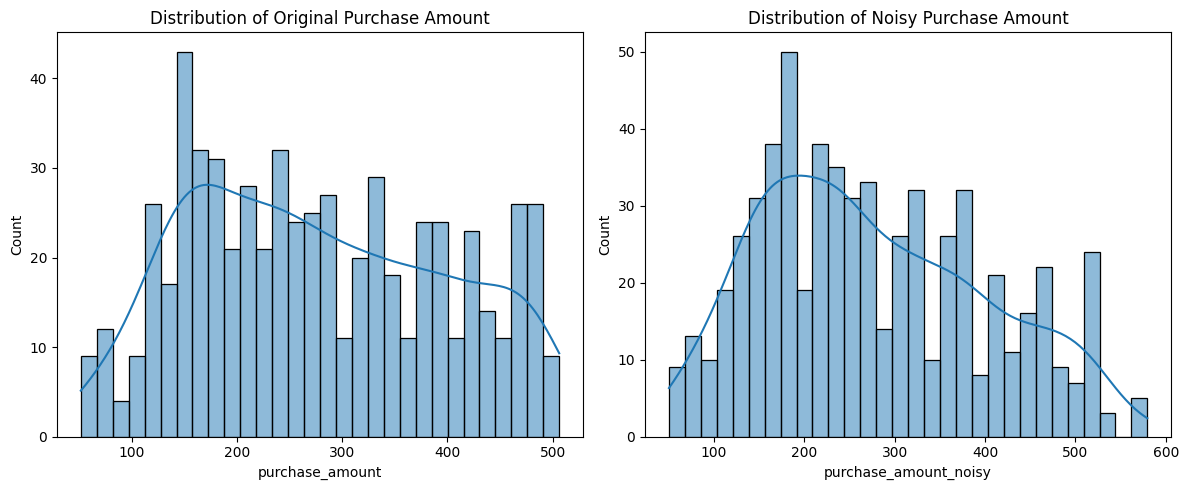

In [ ]:
# Generate describe() reports for numerical columns
numerical_columns = df_final.select_dtypes(include=[np.number]).columns
print("\nStatistical Summary of Numerical Columns:")
print(df_final[numerical_columns].describe())

# Visualize distribution of transaction amounts before and after augmentation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_final['purchase_amount'], bins=30, kde=True)
plt.title('Distribution of Original Purchase Amount')

plt.subplot(1, 2, 2)
sns.histplot(df_final['purchase_amount_noisy'], bins=30, kde=True)
plt.title('Distribution of Noisy Purchase Amount')
plt.tight_layout()
plt.show()

# 3. Feature Selection for Machine Learning

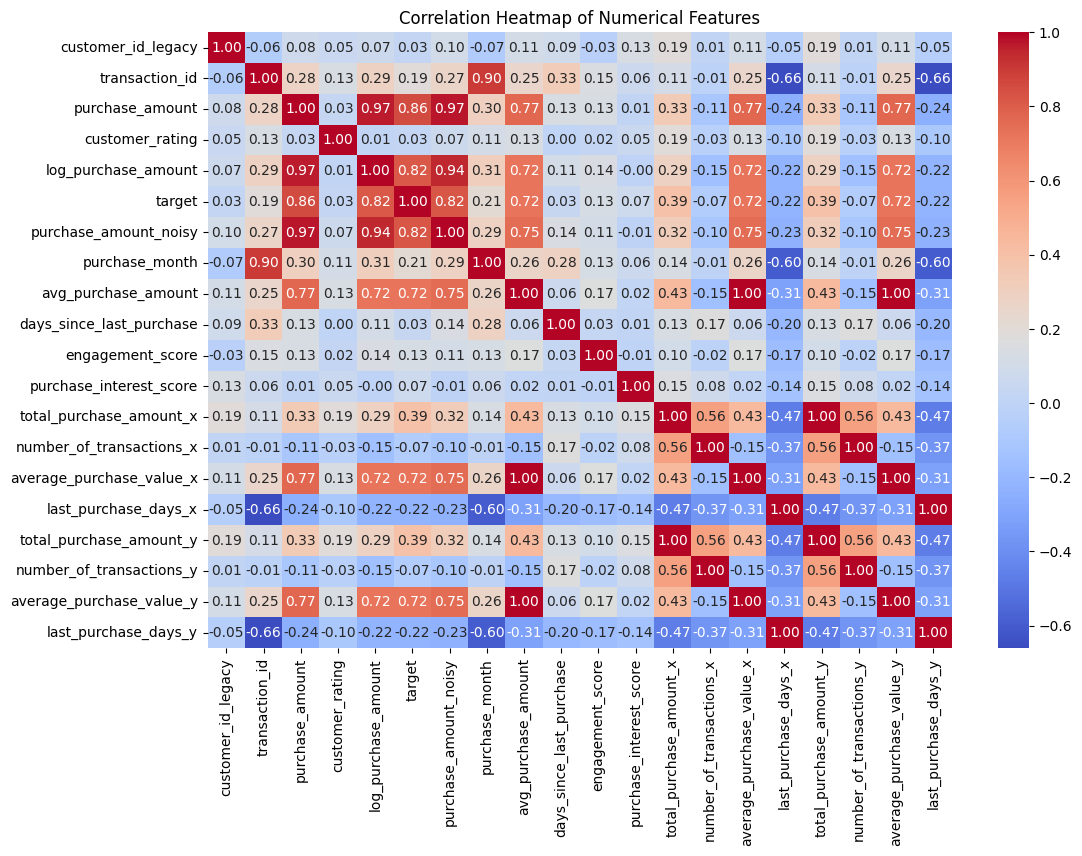


Top 10 Most Important Features:
1. purchase_amount: 1765.97
2. log_purchase_amount: 1301.15
3. purchase_amount_noisy: 1347.93
4. avg_purchase_amount: 709.49
5. total_purchase_amount_x: 118.85
6. average_purchase_value_x: 709.49
7. last_purchase_days_x: 34.56
8. total_purchase_amount_y: 118.85
9. average_purchase_value_y: 709.49
10. last_purchase_days_y: 34.56


In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df_final[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Prepare features and target (predicting 'target' since it's present)
features_to_drop = ['target', 'purchase_date', 'customer_id_legacy', 'customer_id_new',
                    'transaction_id'] + categorical_columns
features_to_drop = [col for col in features_to_drop if col in df_final.columns]
features = df_final.drop(columns=features_to_drop)
X = features.fillna(0)  # Fill NaN for feature selection
y = df_final['target'].fillna(df_final['target'].mean())

# Select top 10 features
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()].tolist()

print("\nTop 10 Most Important Features:")
for i, (feature, score) in enumerate(zip(selected_features, selector.scores_[selector.get_support()]), 1):
    print(f"{i}. {feature}: {score:.2f}")

In [ ]:
# Task 4: Final Data Export
final_columns = (['customer_id_legacy', 'customer_id_new', 'transaction_id', 'purchase_date'] +
                 categorical_columns + selected_features + ['target'])
final_columns = [col for col in final_columns if col in df_final.columns]
final_dataset = df_final[final_columns]

# Save the final dataset
final_dataset.to_csv('final_dataset_ready_7.csv', index=False)
print("\nFinal dataset saved as 'final_dataset_ready_7.csv'")


Final dataset saved as 'final_dataset_ready_7.csv'


# Bonus Challenge

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the final preprocessed dataset
df = pd.read_csv('final_dataset_ready_7.csv')

In [ ]:

# 1. Prepare the data
# Encode categorical variables
le = LabelEncoder()
categorical_columns = ['product_category', 'social_media_platform', 'review_sentiment']
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

# Define features and target
# Use all columns except IDs, dates, and target
features = df.drop(columns=['customer_id_legacy', 'customer_id_new', 'transaction_id',
                           'purchase_date', 'purchase_amount'])
X = features.fillna(0)  # Fill missing values
y = df['purchase_amount']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# 2. Train Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, random_state=42)

In [ ]:
# 3. Make predictions
y_pred = rf_model.predict(X_test)

# 4. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error: 75.80
R² Score: 0.99


In [ ]:

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                     feature  importance
3        log_purchase_amount    0.990242
4      purchase_amount_noisy    0.004569
0           product_category    0.002595
9    total_purchase_amount_y    0.000342
1      social_media_platform    0.000335
11      last_purchase_days_y    0.000316
8       last_purchase_days_x    0.000294
10  average_purchase_value_y    0.000285
6    total_purchase_amount_x    0.000284
7   average_purchase_value_x    0.000271
5        avg_purchase_amount    0.000262
2           review_sentiment    0.000194
12                    target    0.000011


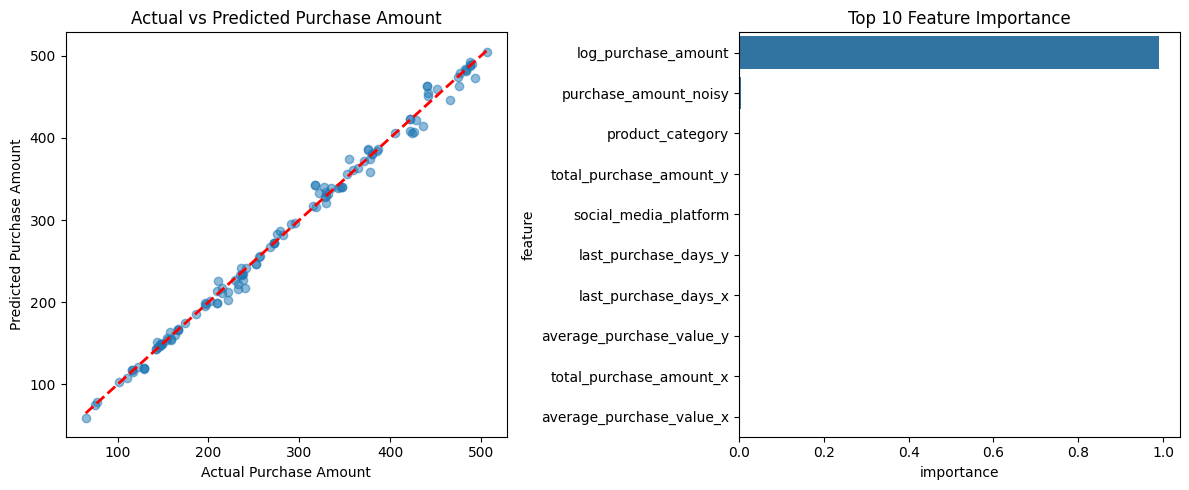

In [ ]:
# 5. Visualize results
plt.figure(figsize=(12, 5))

# Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Purchase Amount')
plt.ylabel('Predicted Purchase Amount')
plt.title('Actual vs Predicted Purchase Amount')

# Feature Importance
plt.subplot(1, 2, 2)
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
# 6. Example prediction for a single customer
sample_customer = X_test.iloc[0:1]
sample_pred = rf_model.predict(sample_customer)
print(f"\nSample Prediction:")
print(f"Features: {sample_customer.values[0]}")
print(f"Actual Purchase Amount: {y_test.iloc[0]:.2f}")
print(f"Predicted Purchase Amount: {sample_pred[0]:.2f}")


Sample Prediction:
Features: [  1.           3.           1.           5.55218935 271.76078396
 325.50138143 651.00276286 325.50138143  24.         651.00276286
 325.50138143  24.           0.        ]
Actual Purchase Amount: 256.80
Predicted Purchase Amount: 256.62
